In [1]:
# load the packages
library(rethinking)
library(brms)
library('readxl')

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: parallel

rethinking (Version 2.13)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent


Loading required package: Rcpp

Loading 'brms' package (version 2.15.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following objects are masked from ‘package:rethinking’:

    LOO, stancode, WAIC


The following object is masked from ‘package:rstan’:

    loo


The following object is masked from ‘package:stat

# Example 2: Estimating the effect of density on guppy survival

## Step 2: Load you data. 

In this Notebook, I will show you how to run some models on data from **The Guppy Project** and published in Reznick et al., 2002. In which he manipulated the density of guppies in natural fish communities of trinidad where predators are absent. This study is one of the first studies to investigate whether guppy populations that live in the absend of predators are *density regulated*. David Reznick et al 2002 went to the fild individually mark each fish and came back after 25 days and estimated the effects of fish density on several life history traits: individual survival, growth rates, and probability of reproduciton, among others. Additionally, they evaluated the influence of body size on those vital rates and how this relationship was change by the density manipulatons. 

In [3]:
S.data = read.csv("../Examples/Reznick et al 2012/Survival.csv")
head(S.data)

,Stream,year,replicate,TREATMENT,survival,sizeclass
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,Aripo,"1,996",1,Decrease (0.5x),0,1
2,Aripo,"1,996",1,Decrease (0.5x),0,1
3,Aripo,"1,996",1,Decrease (0.5x),0,1
4,Aripo,"1,996",1,Decrease (0.5x),1,1
5,Aripo,"1,996",1,Decrease (0.5x),1,1
6,Aripo,"1,996",1,Decrease (0.5x),1,1


In [4]:
S.data$TREATMENT = factor(S.data$TREATMENT)
levels(S.data$TREATMENT)


[1] "Control (1x)"    "Decrease (0.5x)" "Increase (2x)"

To start building some intuition of how model works, we will build some dummy variables that will represent our treatments


In [5]:
levels(S.data$TREATMENT)

[1] "Control (1x)"    "Decrease (0.5x)" "Increase (2x)"

In [6]:
# create dummy variable for the decrease density
S.data$decrease = factor(S.data$TREATMENT)
# make the values 0 or 1
levels(S.data$decrease) = c(0,1,0)
S.data$decrease = as.numeric(as.character(S.data$decrease))
unique(S.data$decrease)

# create dummy variable for the decrease density
S.data$increase = factor(S.data$TREATMENT)
# make the values 0 or 1
levels(S.data$increase) = c(0,0,1)
S.data$increase = as.numeric(as.character(S.data$increase))
unique(S.data$increase)

[1] 1 0

[1] 0 1

To make things easier to interpreat, we create a new varible from the `sizeclass`, but we will center the values to get a meaninful `intercept` ($\alpha$). Here, we will center on `2`, what it means is that now `sizeclass 1 = -1, sizeclass 2 = 0, sizeclass 3 = 1, sizeclass 4 = 2, sizeclass 5 = 3`. So, `intercept` ($\alpha$) of the model will be the estimated survival probability of individuals at `sizeclass 2` in the control pools ( `decrease == 0 & increase == 0`). 

In [7]:
S.data$size_c = S.data$sizeclass - 2

unique(S.data$size_c)

[1] -1  0  1  2  3

# Step 3: Run the model
### Estimating survial probability

So, we are going to model `survival` as a function of sizeclass and the density treatment. First, we are going to start with the 'Rethinking R package', modeling the effects of density. So, always start by writing the model:

`We are using a binomial model because the surival data is represented as 1 (survive) and 0 (death)`

<center> $Surv_{i}$ $\approx$ $binomial(1, p_{i})$, `this is the likelihood`<center>

<center> logit($p_{i}$) = $alpha$ + $\beta_{D}$*decrease$_{i}$ + $\beta_{I}$*increase$_{i}$,  `this is the linear model`<center>

<center> $\alpha \approx normal(0,10)$, `this is the prior for the intercept`<center>

<center> $\beta_{D} \approx normal(0,10)$, `this is the prior for decrease`<center>
 
<center> $\beta_{I} \approx normal(0,10)$, `this is the prior for increase`<center>

    

    

In [8]:
S.m1 = ulam(alist(
    survival ~ dbinom( 1 , p ), # likelihood
    logit(p) <- a + b_D*decrease + # linear model
        b_I*increase,                      # linear model
# piors
    a ~ dnorm(0,10),
    b_D ~ dnorm(0,10),
    b_I ~ dnorm(0,10)
), data = S.data, 
  cores= 2, chains = 2, iter=2000, warmup = 1000)

Removing one or more character or factor variables:

Streamyear



Error in mod$fit_ptr() : 
  Exception: variable does not exist; processing stage=data initialization; variable name=year; base type=vector_d  (in 'model58c4666bc785_c6168fe8547f02eae98c1af2a423aaa9' at line 6)



failed to create the sampler; sampling not done



Stan model 'c6168fe8547f02eae98c1af2a423aaa9' does not contain samples.


ERROR: Error in validObject(.Object): invalid class “ulam” object: invalid object for slot "coef" in class "ulam": got class "NULL", should be or extend class "numeric"


In [9]:
# Look at the summary of the model
precis(S.m1, prob = .95) # rember the values in this table are in the logistic scale

,mean,sd,2.5%,97.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9199481,0.1062958,0.72241086,1.14002312,564.9045,1.001908
b_D,0.3779334,0.1696712,0.05025403,0.71231451,760.6595,1.002910
b_I,-0.3366646,0.1252487,-0.59037517,-0.09715906,586.3875,1.000844


In [9]:
logit(0)

[1] -Inf

In [10]:
logit(1)

[1] Inf

In [14]:
inv_logit(0.9199481) 

[1] 0.7150315

In [13]:
inv_logit(0.9199481 + 0.3779334)

[1] 0.7854782

### Working with posteriors

One of the biggest advantages of using Bayesian model is the use of the posterior samples, which contains all the information from the model parameters and allow you to test hypothesis and simulate predictions.  


In [10]:
# so, let's get the posterior samples
post_S.m1 = extract.samples(S.m1)

Heads up, remember that the parameters estimated in this model are in the logit scale, it is a function of values that range between $]-\infty, +\infty[$. Interestingly, we can convert those values to values between $0$ and $1$ with the *inverse logit* function. You can learn more about it [here](https://en.wikipedia.org/wiki/Logit).

In [11]:
# To convert this values to probabilities, we should inverst logit the values
inv_logit(0) # 50%
inv_logit(0.5) # 62%
inv_logit(0.9) # 71%
inv_logit(3) # 95

[1] 0.5

[1] 0.6224593

[1] 0.7109495

[1] 0.9525741

### Estimating the survival probability of each treatment

In [12]:
post_S.m1$S_control = inv_logit(post_S.m1$a) 
post_S.m1$S_decrease = inv_logit(post_S.m1$a + post_S.m1$b_D ) 
post_S.m1$S_increase = inv_logit(post_S.m1$a + post_S.m1$b_I ) 

# see the results
precis(post_S.m1)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
a,0.9199481,0.10629575,0.7565364,1.0961153,▁▁▂▇▇▃▁▁
b_D,0.3779334,0.16967121,0.1111949,0.6528073,▁▁▁▃▇▇▇▅▂▁▁
b_I,-0.3366646,0.12524866,-0.5379873,-0.1414948,▁▁▂▅▇▇▂▁▁▁
S_control,0.7145372,0.02156167,0.6806013,0.7495315,▁▁▁▃▇▅▂▁▁
S_decrease,0.7846225,0.02250451,0.7479659,0.8193963,▁▁▂▇▇▅▁▁
S_increase,0.6416745,0.01549022,0.6168549,0.6655903,▁▁▁▂▃▇▇▅▂▁▁▁▁


### Testing hypothesis

Testing hypothesis is very easy. For instance:
If guppy populations in low predation habitats are density regulated, then
$H_{1}$= increasing fish density should decrease individual survival probability. So, we use the posterior samples to test this hypothesis.


In [13]:
post_S.m1$S_IvsC  = post_S.m1$S_increase - post_S.m1$S_control 
precis(post_S.m1)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
a,0.91994806,0.10629575,0.7565364,1.09611533,▁▁▂▇▇▃▁▁
b_D,0.37793343,0.16967121,0.1111949,0.65280725,▁▁▁▃▇▇▇▅▂▁▁
b_I,-0.33666458,0.12524866,-0.5379873,-0.14149476,▁▁▂▅▇▇▂▁▁▁
S_control,0.71453722,0.02156167,0.6806013,0.74953153,▁▁▁▃▇▅▂▁▁
S_decrease,0.78462250,0.02250451,0.7479659,0.81939635,▁▁▂▇▇▅▁▁
S_increase,0.64167446,0.01549022,0.6168549,0.66559034,▁▁▁▂▃▇▇▅▂▁▁▁▁
S_IvsC,-0.07286276,0.02642603,-0.1145711,-0.03089344,▁▁▂▇▇▅▂▁▁▁


The test suggest that increasing density reduces survival by approximatly 7.4% (2.9 - 11.6%, CI 95%)

### Additionally, we can test the probability of increasing density results in decreasing survival probability.

It is basically counting. You only have to count how many posterior samples of the `S_IvsC < 0` and divided by the total number of samples. 


In [14]:
p = length(which(post_S.m1$S_IvsC<0))
N = length(post_S.m1$S_IvsC)
(p/N) * 100

[1] 99.7

Increasing fish density decreases guppy survival probability with a 99.75% certainty

## Improve the model

Now, this experiment the data is not independent. It is replycated several times and it is nested within rivers, so we have to add random effects. Additoinaly, we also want to introduce the interaction of density with size class.

Let's write the new model:

<center> $Surv_{i}$ $\approx$ $binomial(1, p_{i})$, `this is the likelihood` <center>

<center>logit($p_{i}$) = $alpha$ + $\beta_{D}$*decrease$_{i}$ + $\beta_{I}$*increase$_{i}$  + size_c$_{i}$ * ($\beta_{S}$    + $\beta_{SxD}$ * decrease$_{i}$ + $\beta_{SxI}$*increase$_{i}$),  `this is the linear model`<center>

<center>$\alpha \approx normal(0,10)$, `this is the prior for the intercept`<center>

<center>$\beta_{S} \approx normal(0,10)$, `this is the prior for sizeclass`<center>

<center>$\beta_{D} \approx normal(0,10)$, `this is the prior for decrease`<center>
 
<center>$\beta_{I} \approx normal(0,10)$, `this is the prior for increase`<center>

<center>$\beta_{SxD} \approx normal(0,10)$, `this is the prior for interaction`<center>

<center>$\beta_{SxI} \approx normal(0,10)$, `this is the prior for interaction`<center>

<center>$\alpha$_S$_{Stream_{i}}$ ~ normal(0,$\sigma_{Stream})$, `this is the prior for the randome effect stream`<center>

<center>$\sigma_{Stream} \approx cauchy(0,2)$, `this is the prior for the random error`<center>

<center>$\alpha$_R$_{replicate_{i}}$ ~ normal(0,$\sigma_{replicate})$, `this is the prior for the randome effect replicate`<center>

<center>$\sigma_{replicate} \approx cauchy(0,2)$, `this is the prior for the random error`<center>





In [15]:
# we can use the glimmer function to get model.

glimmer(survival ~ size_c*decrease + size_c*increase + (1|replicate) + (1|Stream) , family = binomial(), data = S.data)

Warning message in coerce_index(data[[group_var]]):
“NAs introduced by coercion”


alist(
    survival ~ dbinom( 1 , p ),
    logit(p) <- Intercept +
        b_size_c*size_c +
        b_decrease*decrease +
        b_increase*increase +
        b_size_c_X_decrease*size_c_X_decrease +
        b_size_c_X_increase*size_c_X_increase +
        v_replicate_Intercept[replicate] +
        v_Stream_Intercept[Stream],
    Intercept ~ dnorm(0,10),
    b_size_c ~ dnorm(0,10),
    b_decrease ~ dnorm(0,10),
    b_increase ~ dnorm(0,10),
    b_size_c_X_decrease ~ dnorm(0,10),
    b_size_c_X_increase ~ dnorm(0,10),
    v_replicate_Intercept[replicate] ~ dnorm(0,sigma_replicate),
    sigma_replicate ~ dcauchy(0,2),
    v_Stream_Intercept[Stream] ~ dnorm(0,sigma_Stream),
    sigma_Stream ~ dcauchy(0,2)
)


In [16]:
S.data$Stream = as.factor(S.data$Stream)
levels(S.data$Stream) <- 1:length(levels(S.data$Stream)) # convert the streams to numbers to run the model.

In [17]:
S.m2 = ulam(
alist(
    survival ~ dbinom( 1 , p ),
    logit(p) <- a +
        b_S*size_c +
        b_D*decrease +
        b_I*increase +
        b_SxD*size_c*decrease +
        b_SxI*size_c*increase +
        v_replicate_Intercept[replicate] +
        v_Stream_Intercept[Stream],
    a ~ dnorm(0,10),
    b_S ~ dnorm(0,10),
    b_D ~ dnorm(0,10),
    b_I ~ dnorm(0,10),
    b_SxD ~ dnorm(0,10),
    b_SxI ~ dnorm(0,10),
    v_replicate_Intercept[replicate] ~ dnorm(0,sigma_replicate),
    sigma_replicate ~ dcauchy(0,2),
    v_Stream_Intercept[Stream] ~ dnorm(0,sigma_Stream),
    sigma_Stream ~ dcauchy(0,2)
), data = S.data, 
  cores= 4, chains = 4, iter=2000, warmup = 1000
) 

In [18]:
# Look at the summary of the model
precis(S.m2, prob = .95) # rember the values in this table are in the logistic scale

7 vector or matrix parameters hidden. Use depth=2 to show them.



,mean,sd,2.5%,97.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9552685,1.26998847,-1.5172405,3.65587198,747.0874,1.005543
b_S,0.3409654,0.09673032,0.1532594,0.52593384,1468.7807,1.001189
b_D,0.5851823,0.18804126,0.2208289,0.96155606,2292.4838,1.001547
b_I,-0.1763107,0.13930946,-0.4450764,0.10767641,2142.1840,1.000705
b_SxD,-0.6224792,0.14585462,-0.9054222,-0.33965876,1746.4615,1.001560
b_SxI,-0.2589119,0.11095655,-0.4723207,-0.04488091,1521.0320,1.001697
sigma_replicate,1.3957534,1.52812409,0.2171571,5.41005884,785.4921,1.002968
sigma_Stream,0.4895213,0.28432718,0.1808819,1.24578185,1375.9374,1.000218


In [19]:
# so, let's get the posterior samples
post_S.m2 = extract.samples(S.m2)
post_S.m2$S_control = inv_logit(post_S.m2$a) 
post_S.m2$S_decrease = inv_logit(post_S.m2$a + post_S.m2$b_D ) 
post_S.m2$S_increase = inv_logit(post_S.m2$a + post_S.m2$b_I ) 
precis(post_S.m2, prob = .95)

7 vector or matrix parameters hidden. Use depth=2 to show them.



,mean,sd,2.5%,97.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
a,0.9552685,1.26998847,-1.5172405,3.65587198,▁▁▁▁▁▁▇▁▁▁▁▁
b_S,0.3409654,0.09673032,0.1532594,0.52593384,▁▁▅▇▃▁▁▁
b_D,0.5851823,0.18804126,0.2208289,0.96155606,▁▁▁▂▃▅▇▇▅▂▁▁▁▁
b_I,-0.1763107,0.13930946,-0.4450764,0.10767641,▁▁▁▃▇▇▅▂▁▁▁
b_SxD,-0.6224792,0.14585462,-0.9054222,-0.33965876,▁▁▁▂▅▇▇▃▁▁▁
b_SxI,-0.2589119,0.11095655,-0.4723207,-0.04488091,▁▁▁▂▅▇▅▂▁▁
sigma_replicate,1.3957534,1.52812409,0.2171571,5.41005884,▇▁▁▁▁▁▁▁▁▁▁▁
sigma_Stream,0.4895213,0.28432718,0.1808819,1.24578185,▁▇▅▂▁▁▁▁▁▁▁▁▁▁▁
S_control,0.6907483,0.18406032,0.1798686,0.97481187,▁▁▁▁▁▂▅▇▃▂


In [20]:
post_S.m2$S_IvsC  = post_S.m2$S_increase - post_S.m2$S_control 
precis(post_S.m2)

7 vector or matrix parameters hidden. Use depth=2 to show them.



,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
a,0.95526846,1.26998847,-0.72824134,2.759136782,▁▁▁▁▁▁▇▁▁▁▁▁
b_S,0.34096539,0.09673032,0.18769305,0.497196265,▁▁▅▇▃▁▁▁
b_D,0.58518232,0.18804126,0.28991555,0.890093191,▁▁▁▂▃▅▇▇▅▂▁▁▁▁
b_I,-0.17631067,0.13930946,-0.39455715,0.046139553,▁▁▁▃▇▇▅▂▁▁▁
b_SxD,-0.62247921,0.14585462,-0.85825628,-0.390184041,▁▁▁▂▅▇▇▃▁▁▁
b_SxI,-0.25891189,0.11095655,-0.43516496,-0.082311880,▁▁▁▂▅▇▅▂▁▁
sigma_replicate,1.39575336,1.52812409,0.27439127,3.875189047,▇▁▁▁▁▁▁▁▁▁▁▁
sigma_Stream,0.48952129,0.28432718,0.20825527,0.993954178,▁▇▅▂▁▁▁▁▁▁▁▁▁▁▁
S_control,0.69074831,0.18406032,0.32558077,0.940426883,▁▁▁▁▁▂▅▇▃▂


## Step 4: plot your results, draw conclusions, and so on...

Plotting the results from Bayesian models is very intuitive and relatively easy to do: first, you need to recrate the model with the posteriors. Second, chose the values you want to model, and third, test you hypothesis.

For instanace, next we will plot the results from the model and compare it with the data.

We start by creating a function that allow us to model the results from the parameters in the posterior distributions.

In [24]:
predict.link = function(posteriors = NULL, sizeclass = NULL, decrease = 0, increase = 0, center = 2){

    z = sizeclass - center
    
pred=  with(posteriors, a + b_S*z + b_D * decrease + b_I * increase + 
         b_SxD * decrease*z + b_SxI * increase * z
        )

    return(inv_logit(pred))
}

In [33]:
pred.1 = predict.link(posteriors = post_S.m2, sizeclass = 1, decrease = 0, center = 2)
pred.2 = predict.link(posteriors = post_S.m2, sizeclass = 2, decrease = 0, center = 2)

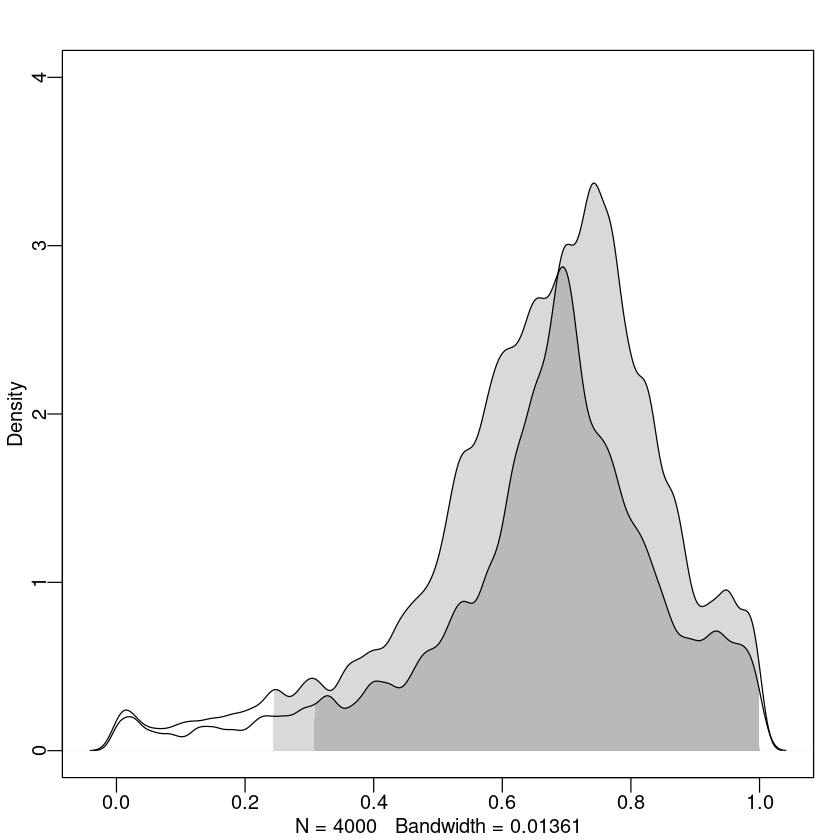

In [35]:
dens(pred.1, show.HPDI = 0.95, ylim = c(0,4))
dens(pred.2, show.HPDI = 0.95, add = TRUE)

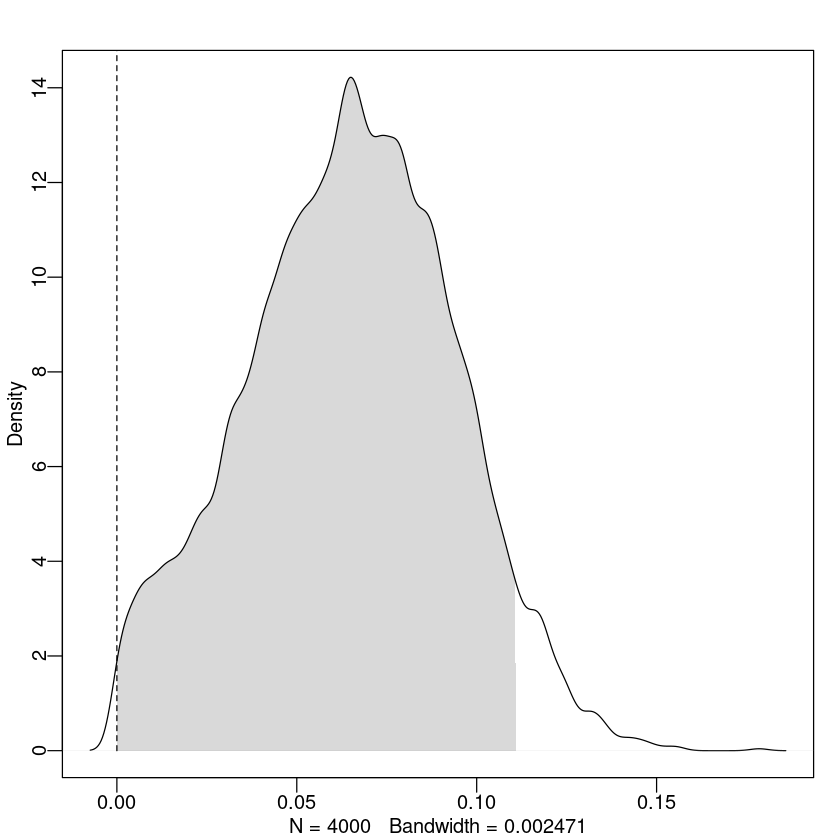

In [37]:
dens(pred.2-pred.1, show.HPDI = .95, show.zero = TRUE)

In [43]:
sizes = 1:5
Control = sapply(1:length(sizes), function(i) predict.link(posteriors = post_S.m2, sizeclass =sizes[i], 
                                                           decrease = 0, increase = 0, center = 2))
Decrease = sapply(1:length(sizes), function(i) predict.link(posteriors = post_S.m2, sizeclass =sizes[i], 
                                                           decrease = 1, increase = 0, center = 2))

Increase = sapply(1:length(sizes), function(i) predict.link(posteriors = post_S.m2, sizeclass =sizes[i], 
                                                           decrease = 0, increase = 1, center = 2))

                  
# add points representing posterior means
str(Control)

 num [1:4000, 1:5] 0.693 0.653 0.594 0.488 0.719 ...


In [46]:
# estimate the posterior mean for each size class in each treatment

m.Control = apply(Control, 2, mean)
m.Decrease = apply(Decrease, 2, mean)
m.Increase = apply(Increase, 2, mean)

In [65]:
# estimate the uncertainty = complement intervals, credible intervals, etc.

ci.Control = apply(Control, 2, HPDI, prob = .89)
ci.Decrease = apply(Decrease, 2, HPDI, prob = .89)
ci.Increase = apply(Increase, 2, HPDI, prob = .89)

ci.Control = t(ci.Control)
ci.Decrease = t(ci.Decrease)
ci.Increase = t(ci.Increase)

In [66]:
ci.Control[,1:2]

|0.89,0.89|
0.3873408,0.9999722
0.4750913,0.9999777
0.5577919,0.9999829
0.6348297,0.9999893
0.7002703,0.9999933


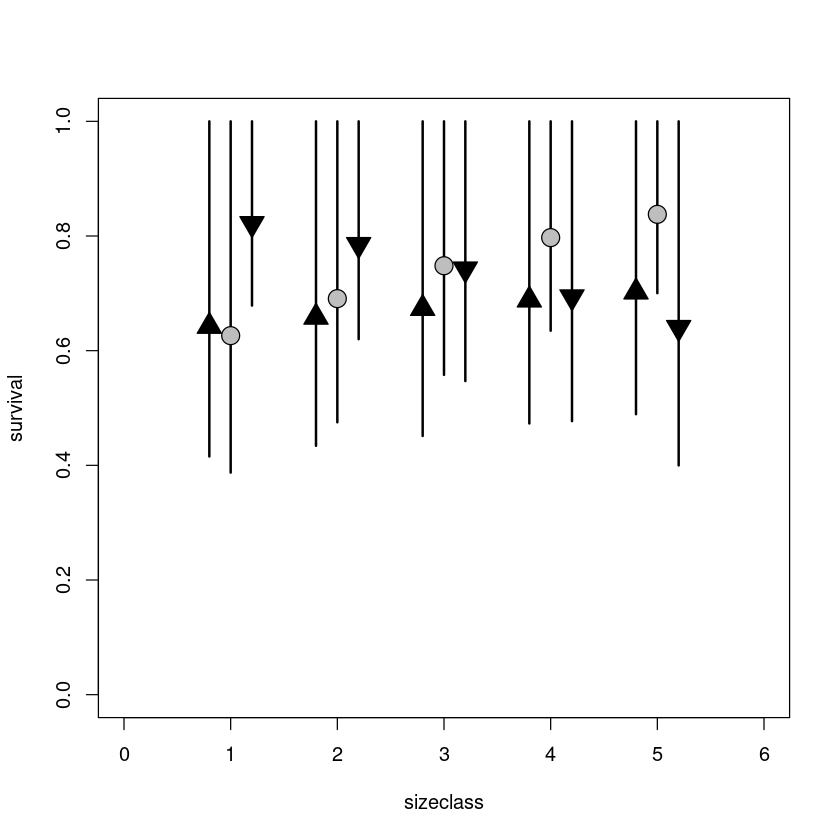

In [70]:
plot(survival ~ sizeclass, S.data, pch = '', xlim= c(0, 6))

segments(x0 = sizes, x1 = sizes, y0 = ci.Control[,1], y1 = ci.Control[,2], lwd = 2, lty = 1 )
points(x = sizes, y = m.Control, pch=21, bg = "gray", cex = 2)


segments(x0 = (sizes + 0.2), x1 = (sizes +0.2), y0 = ci.Decrease[,1], y1 = ci.Decrease[,2], lwd = 2, lty = 1)
points(x = sizes+ 0.2, y = m.Decrease, pch=25, bg = "black", cex = 2)


segments(x0 = (sizes - 0.2), x1 = (sizes  - 0.2), y0 = ci.Increase[,1], y1 = ci.Increase[,2], lwd = 2, lty = 1)
points(x = sizes - 0.2, y = m.Increase, pch=24, bg = "black", cex = 2)